# 🌱 Soil Classification Challenge - Part 2
---

This is the notebook for classifying whether an image belongs to soil or not.

The project uses Data Enhancement techniques ensuring a robust pipeline based on ResNet50 for highly accurate classifications.

> This notebook borrows heavily from our Part-1 notebook

### 👥 About US

Our team "Synfire Chain" is named after feed-forward network of neurons, and it consists of 2 members:
- Yash Kumar, B.S @ IITM
- Astitva Agarwal, B.S @ IITM

#### **🏆 We achieved a near-perfect F1 score on leaderboard: 0.99 🎯**

## **1. Imports and Setups**

Setting up all the necessary libraries for our soil classification project.

We're using 
- PyTorch for deep learning
- Pandas for data handling
- Matplotlib for visualizations.
  
The key libraries here are torchvision (for computer vision tasks) and PIL (for image processing).

In [1]:
import os
import shutil
import random
import time
from glob import glob

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

from tqdm import tqdm

from sklearn.metrics import (
    f1_score, precision_score, confusion_matrix, 
    precision_recall_curve, accuracy_score,
    ConfusionMatrixDisplay, PrecisionRecallDisplay
)
from sklearn.preprocessing import label_binarize

## **2. Data Setup**

**We found the train data to be highly imbalanced, with every image there belonging to soil category. We tried to build and Autoencoder on it but the F1 Score was quite low hovering around ~0.6. This was not adequate.**

Hence, we came up with Data Enhancement techniques to balance the classes.

- `image_directory` : Provided train set
- `negative_directory` : Synthetic negative samples. About 1200 images
- `output_dir` : Directory to save split data
- `raw_images` : Common directory for negative and positive samples, used for randomisation

In [2]:
image_directory = "../data/soil_competition-2025/train"
negative_directory = "../data/NF/images"
output_dir = "./new-data"
raw_images = './new-data/raw/images'
train_ratio = 0.8


for split in ["train", "val"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
os.makedirs('./new-data/raw', exist_ok=True)
os.makedirs(raw_images, exist_ok=True)

Below script combines labels from positive and negative dataset into a single CSV file for further processing.

- Both datasets are merged into one unified dataframe.
- The combined labels are then saved as a CSV file.

In [ ]:
label_path = './new-data/raw/labels.csv'

df1 = pd.read_csv('../data/soil_competition-2025/train_labels.csv')
df2 = pd.read_csv('../data/NF/image_net_labels_negative.csv')

df_combined = pd.concat([df1, df2], ignore_index=True)
df_combined.to_csv(label_path, index=False)

print("Successfully merged csv")
df_combined.head()

Successfully merged csv


,image_id,label
0,img_ed005410.jpg,1
1,img_0c5ecd2a.jpg,1
2,img_ed713bb5.jpg,1
3,img_12c58874.jpg,1
4,img_eff357af.jpg,1


Copy over images from both datasets to common directory

In [4]:
for source_dir in [image_directory, negative_directory]:
    print(f"Processing directory: {source_dir}")  # Print the directory being processed
    
    # Get all files recursively first, so tqdm knows total length
    all_files = [file_path for file_path in glob(os.path.join(source_dir, "**/*"), recursive=True) if os.path.isfile(file_path)]
    
    for file_path in tqdm(all_files, desc=f"Copying files from {source_dir}"):
        filename = os.path.basename(file_path)
        shutil.copy2(file_path, os.path.join(raw_images, filename))

print("All files copied successfully.")


Processing directory: /kaggle/input/soil-classification-part-2/soil_competition-2025/train


Copying files from /kaggle/input/soil-classification-part-2/soil_competition-2025/train: 100%|██████████| 1222/1222 [00:11<00:00, 103.67it/s]


Processing directory: /kaggle/input/imagenet-1000/NF/images


Copying files from /kaggle/input/imagenet-1000/NF/images: 100%|██████████| 1200/1200 [00:03<00:00, 305.49it/s]

All files copied successfully.


## **2. Data Exploration and Visualization**

Randomly selects up to 6 images from training data and displays them in a 2x3 grid with filenames as titles for quick visual inspection.

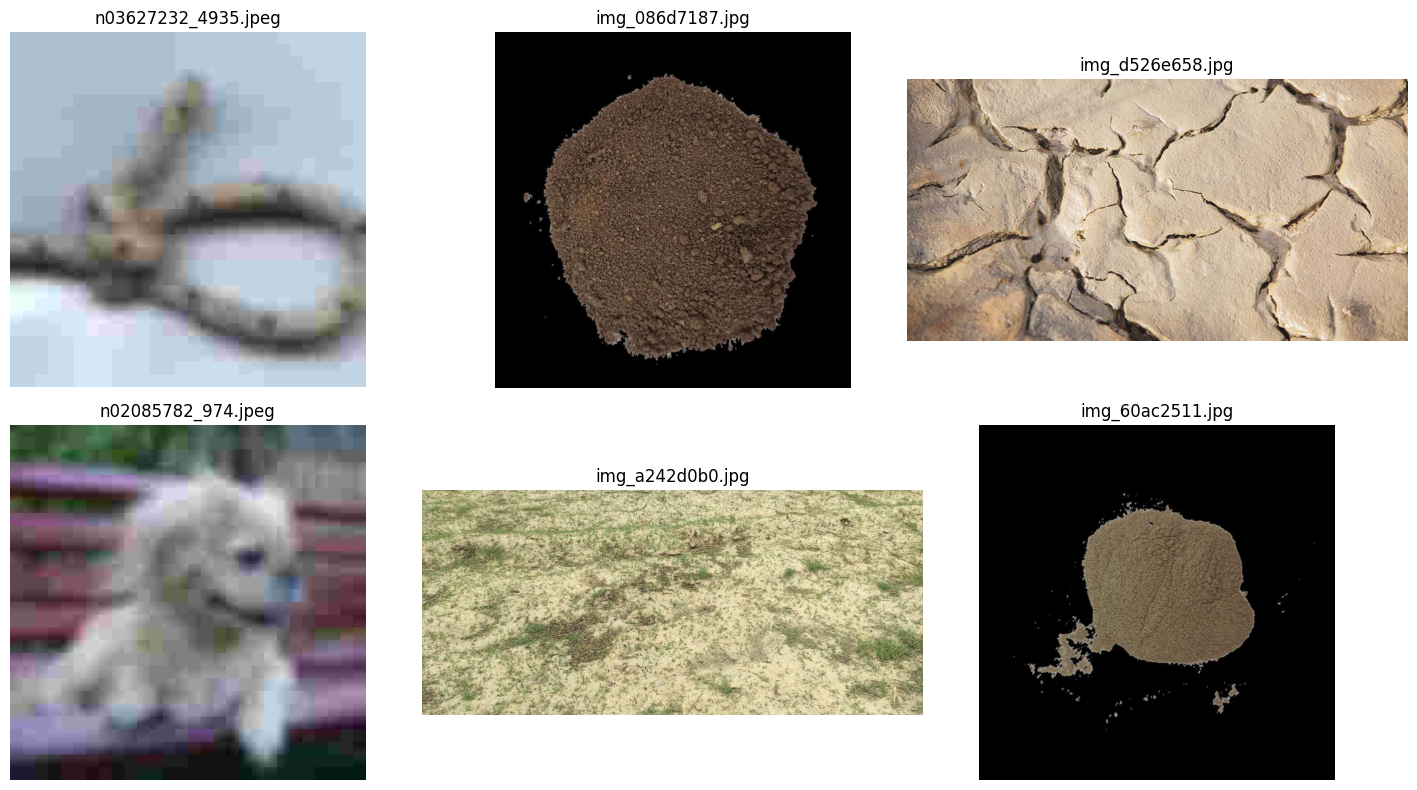

In [5]:
image_files = [f for f in os.listdir(raw_images)]

# Select 6 random images
sample_files = random.sample(image_files, min(6, len(image_files)))

plt.figure(figsize=(15, 8))
for i, img_file in enumerate(sample_files, 1):
    img_path = os.path.join(raw_images, img_file)
    img = Image.open(img_path)
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')
plt.tight_layout()
plt.show()

## **3. Data Preprocessing**

This is a crucial step where we organize our data properly. We're splitting the data into training and validation sets while making sure each category is represented in both sets.

The 80-20 split is a common practice - 80% for training and 20% for validation.

In [6]:
# Dataframe containing image-label mapping for finetuning
df_train_labels = pd.read_csv(label_path)

all_tasks = []

# Group and split
for label, group in df_train_labels.groupby('label'):
    image_ids = group['image_id'].tolist()
    random.shuffle(image_ids)

    # Compute index at which to split for training and validation
    split_index = int(len(image_ids) * train_ratio)
    
    for split_name, split_imgs in zip(['train', 'val'], [image_ids[:split_index], image_ids[split_index:]]):
        for img_id in split_imgs:
            src = os.path.join(raw_images, img_id)
            dst = os.path.join(output_dir, split_name, str(label), img_id)
            all_tasks.append((src, dst))

for src, dst in tqdm(all_tasks, desc="Copying images"):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

print("✅ Done splitting into train and val!")

Copying images: 100%|██████████| 2422/2422 [00:00<00:00, 6654.11it/s]

✅ Done splitting into train and val!


## **4. Data Transformations and Augmentation**

Data transformations are essential for deep learning models. We're doing three
main things here:

1. Resize images to 224x224 - this is the standard input size for most pre-trained
   models like ResNet50
2. Convert to tensor - PyTorch needs data in tensor format
3. Normalize using ImageNet statistics - since we're using a pre-trained model,
   we need to use the same normalization it was trained with

These transformations ensure our images are in the right format and scale for
the pre-trained ResNet50 model.

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize to model's expected input size
    transforms.ToTensor(),                   # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize to match ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

## **5. Dataloader Setup**

PyTorch's ImageFolder is incredibly convenient for image classification tasks. It automatically creates class labels based on folder names and handles the dataset structure for us. The DataLoader then handles batching, shuffling, and loading data efficiently during training.

We shuffle the training data to prevent the model from learning any ordering patterns, but keep validation data unshuffled since we just need consistent evaluation results.

In [ ]:
train_dir = "./new-data/train/"
val_dir = "./new-data/val"

# this dataset will later be used with our model
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Number of labels detected: {len(train_dataset.classes)}")
print(f"Labels: {train_dataset.classes}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Number of labels detected: 2
Labels: ['0', '1']
Training images: 1935
Validation images: 485


## **6. Model Setup**

We're using transfer learning with ResNet50, which is a powerful approach for image classification. Instead of training a model from scratch, we start with a model that's already been trained on millions of images from ImageNet.

The key modification here is replacing the final classification layer (fc) to match our number of soil types. This way, we keep all the learned features from ImageNet but adapt the final decision-making layer for our specific task.

In [67]:
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

# Replace the final layer to match our number of classes
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

Setting up the training process involves several important decisions:

1. Device selection - use GPU if available for much faster training
2. Loss function - CrossEntropyLoss is standard for multi-class classification
3. Optimizer - Adam is generally reliable and works well with transfer learning
4. Learning rate - 0.001 is conservative but safe for fine-tuning pre-trained models

We also clean up any previous model saves to start fresh.

In [ ]:
model_path = os.path.join(output_dir, "best_model.pth")

# Clean up previous model saves
if os.path.exists(model_path):
    os.remove(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## **7. Train Model**

This is the heart of our machine learning pipeline. We're implementing several
best practices here:

1. Early stopping - prevents overfitting by stopping when validation performance
   stops improving
2. Model checkpointing - saves the best model based on F1 score
3. F1 score tracking - provides a more balanced metric than accuracy, especially
   important as our categories are not well balanced
4. Progress tracking - helps monitor training progress and debug issues

The training loop alternates between training mode (where the model learns) and
evaluation mode (where we test performance without updating weights).

In [ ]:
best_val_acc = 0.0
best_f1 = 0.0
patience = 3
trigger_times = 0
num_epochs = 20
epoch_completed = 0

train_losses = []
val_losses = []
train_times = []
accuracies = []
precisions = []
f1_scores = []
conf_matrices = []
pr_curves = []

print("Starting training...")
print("=" * 50)

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    start_time = time.time()

    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # shape [batch_size, 2]
        loss = criterion(outputs, labels)  # CrossEntropyLoss expects raw logits + integer labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    epoch_time = time.time() - start_time
    train_times.append(epoch_time)

    print(f"📉 Average training loss: {avg_train_loss:.4f}")
    print(f"⏱️ Training time: {epoch_time:.2f} seconds")

    model.eval()
    running_val_loss = 0.0
    all_probs = []
    all_preds = []
    all_labels = []

    val_bar = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # [batch_size, 2]
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)  # [batch_size, 2]
            preds = torch.argmax(probs, dim=1)  # predicted class 0 or 1

            all_probs.extend(probs[:, 1].cpu().numpy())  # positive class probs
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    pr_precision, pr_recall, _ = precision_recall_curve(all_labels, all_probs, pos_label=1)

    accuracies.append(acc)
    precisions.append(prec)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)
    pr_curves.append((pr_precision, pr_recall))

    print(f"✅ Validation Accuracy: {acc:.4f}")
    print(f"🎯 Precision: {prec:.4f}")
    print(f"🎯 F1 Score: {f1:.4f}")
    print(f"📉 Average Validation Loss: {avg_val_loss:.4f}")
    print(f"🧮 Confusion Matrix:\n{conf_matrix}")

    epoch_completed += 1

    if f1 > best_f1:
        best_f1 = f1
        trigger_times = 0
        torch.save(model.state_dict(), model_path)
        print(f"💾 New best model saved (F1: {f1:.4f})")
    else:
        trigger_times += 1
        print(f"⚠️ No improvement. Patience: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("🛑 Early stopping activated.")
            break

print("\n" + "=" * 50)
print("Training completed!")


Starting training...

🔁 Epoch 1/20


📉 Average training loss: 0.0053
⏱️ Training time: 18.78 seconds


✅ Validation Accuracy: 1.0000
🎯 Precision: 1.0000
🎯 F1 Score: 1.0000
📉 Average Validation Loss: 0.0010
🧮 Confusion Matrix:
[[240   0]
 [  0 245]]
💾 New best model saved (F1: 1.0000)

🔁 Epoch 2/20


📉 Average training loss: 0.0007
⏱️ Training time: 18.78 seconds


✅ Validation Accuracy: 1.0000
🎯 Precision: 1.0000
🎯 F1 Score: 1.0000
📉 Average Validation Loss: 0.0003
🧮 Confusion Matrix:
[[240   0]
 [  0 245]]
⚠️ No improvement. Patience: 1/3

🔁 Epoch 3/20


📉 Average training loss: 0.0011
⏱️ Training time: 18.80 seconds


✅ Validation Accuracy: 1.0000
🎯 Precision: 1.0000
🎯 F1 Score: 1.0000
📉 Average Validation Loss: 0.0007
🧮 Confusion Matrix:
[[240   0]
 [  0 245]]
⚠️ No improvement. Patience: 2/3

🔁 Epoch 4/20


📉 Average training loss: 0.0005
⏱️ Training time: 18.67 seconds


✅ Validation Accuracy: 1.0000
🎯 Precision: 1.0000
🎯 F1 Score: 1.0000
📉 Average Validation Loss: 0.0002
🧮 Confusion Matrix:
[[240   0]
 [  0 245]]
⚠️ No improvement. Patience: 3/3
🛑 Early stopping activated.

Training completed!


## **9. Training Visualisation**

Visualizing training progress helps us understand how well our model learned.
The loss curves show us if the model is learning (decreasing loss) and whether
it's overfitting (training loss much lower than validation loss).

Ideally, we want to see both losses decreasing and staying relatively close
to each other.

We have computed the following:

- Accuracy
- Precision
- F1 Score
- Training Time per Epoch
- Training Losses
- Precision-Recall Curve
- Confusion Matrix (TP,TN,FP,FN)

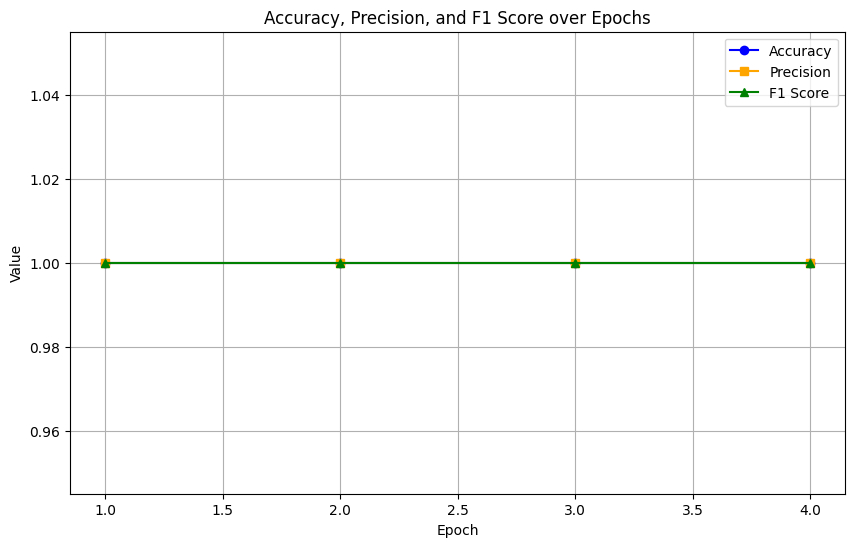

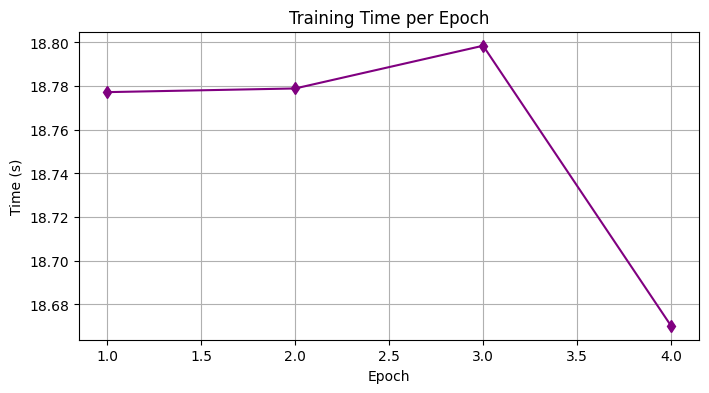

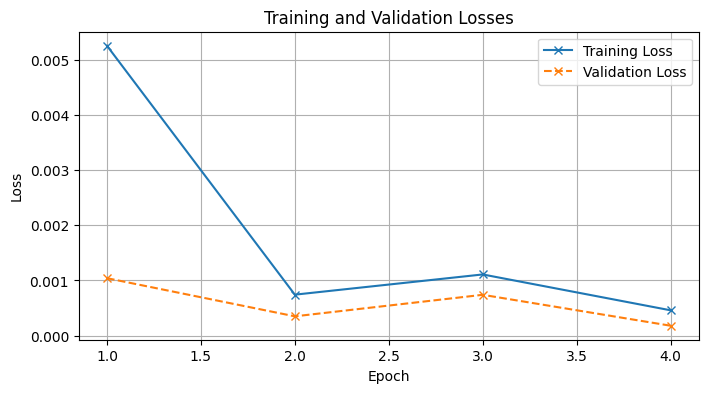

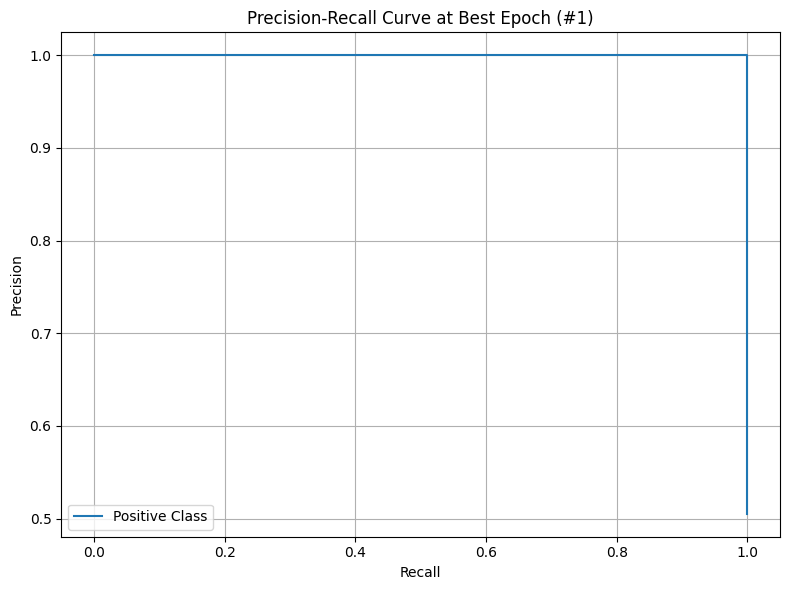

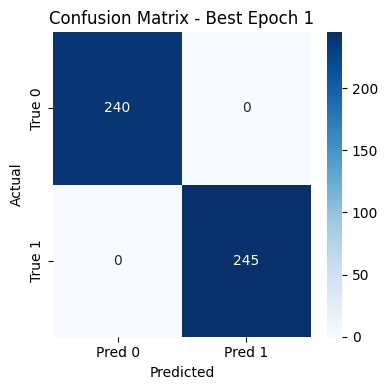

In [77]:
epoch_arr = range(1, epoch_completed + 1)

# --- 1. Accuracy, Precision and F1 over Epochs ---
plt.figure(figsize=(10, 6))
plt.plot(epoch_arr, accuracies, marker='o', label='Accuracy', color='blue')
plt.plot(epoch_arr, precisions, marker='s', label='Precision', color='orange')
plt.plot(epoch_arr, f1_scores, marker='^', label='F1 Score', color='green')
plt.title('Accuracy, Precision, and F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

# --- 2. Training Time per Epoch ---
plt.figure(figsize=(8, 4))
plt.plot(epoch_arr, train_times, marker='d', color='purple')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.grid(True)
plt.show()

# --- 3. Training Losses over Epochs ---
plt.figure(figsize=(8, 4))
plt.plot(epoch_arr, train_losses, marker='x', label='Training Loss')
plt.plot(epoch_arr, val_losses, marker='x', linestyle='--', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 4. PR Curve ---
best_epoch = np.argmax(f1_scores)

plt.figure(figsize=(8, 6))
precision, recall = pr_curves[best_epoch]
plt.plot(recall, precision, label='Positive Class')

plt.title(f'Precision-Recall Curve at Best Epoch (#{best_epoch + 1})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# --- 5. Confusion Matrix (for each epoch) ---
best_cm = conf_matrices[best_epoch]

plt.figure(figsize=(4, 4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title(f'Confusion Matrix - Best Epoch {best_epoch + 1}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## **This model uses pretrained weights from ResNet50 hence very less epoch were needed to correctly classify**

## **10. Model Evaluation**

Loading our best saved model and testing it on some validation images gives us
a qualitative sense of how well it's performing. This visual inspection can
reveal patterns in errors and help us understand the model's strengths and
weaknesses.

Green titles indicate correct predictions, red titles show mistakes.

In [ ]:
model.load_state_dict(torch.load(model_path))
model = model.to(device)

model.eval()  # Set model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

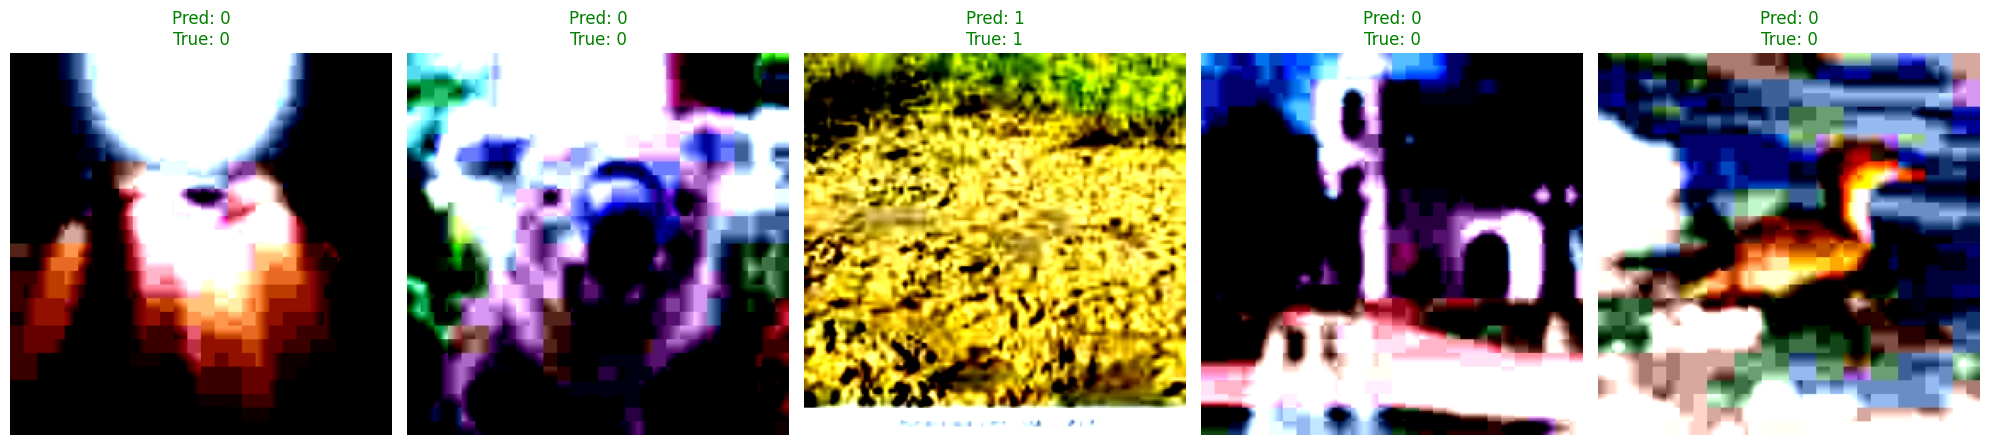

In [ ]:
# Load validation dataset
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
class_labels = val_dataset.classes  # GBIF ID folder names

# Select 5 random images
random_indices = random.sample(range(len(val_dataset)), 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    image, true_label_idx = val_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
    _, pred_idx = torch.max(output, 1)

    predicted_label = class_labels[pred_idx.item()]
    true_label = class_labels[true_label_idx]

    # Color the title green if correct, red if wrong
    is_correct = predicted_label == true_label
    color = 'green' if is_correct else 'red'

    # Display image and result
    axes[i].imshow(image.permute(1, 2, 0).numpy())  # Convert CHW to HWC
    axes[i].set_title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## **11. Prepare `submission.csv`**

For the test set, we need a custom dataset class because the test images don't have labels and aren't organized in class folders. This custom class handles loading test images and keeping track of their filenames so we can create proper submissions.

This is a common pattern when working with competition datasets where test data comes as a flat directory of images.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_names = os.listdir(test_dir)
        self.image_names = [img for img in self.image_names]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

test_dir = "../data/soil_competition-2025/test/"
test_dataset = TestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

The final step is generating predictions for all test images and creating a submission file. We process images in batches for efficiency and convert the model's numeric predictions back to soil type names.

In [81]:
image_ids = []
predicted_labels = []

# Create mapping from class indices back to class names
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

print("Generating predictions for test set...")

with torch.no_grad():
    for images, image_names in test_loader:
        images = images.to(device)
        outputs = model(images)           # Raw logits
        _, preds = torch.max(outputs, 1) # Get class index with highest score

        preds = preds.cpu().numpy()
        
        # Convert predictions to class names and store with image names     
        for img_name, pred_idx in zip(image_names, preds):
            image_ids.append(img_name)
            predicted_labels.append(idx_to_class[pred_idx])

# Create DataFrame for submission
submission_df = pd.DataFrame({
    "image_id": image_ids,
    "label": predicted_labels
})

submission_df.to_csv("submission.csv", index=False)

print("✅ Submission file created successfully!")
print(f"Total predictions made: {len(submission_df)}")
print("\nSample predictions:")
print(submission_df.head())

Generating predictions for test set...
✅ Submission file created successfully!
Total predictions made: 967

Sample predictions:
                               image_id label
0  465084323936570da664f0ca8dc90326.jpg     0
1  1aa0b12029d35e778dba5bff1255c638.jpg     1
2  6df2c3dcd4fb59298c7a73467ea72eeb.jpg     0
3  107f25ebd87f581ea57c630a2dcdf50c.jpg     1
4  dc35d58782615e4f9582c6b32c8b956e.jpg     0
